<a href="https://colab.research.google.com/github/allardolthof/hello-world/blob/master/test_NLP_Bidirectional_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import modules

In [0]:
##%%writefile setup.sh

##git clone https://github.com/NVIDIA/apex
##pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex


In [0]:
##!sh setup.sh

In [10]:
##!pip install simpletransformers

import numpy as np #AO
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

##from simpletransformers.classification import ClassificationModel
##import logging

from sklearn.metrics import balanced_accuracy_score
#from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

import keras.backend as K





Using TensorFlow backend.


# Import data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df = pd.read_excel('/content/drive/My Drive/Fracture_data2018_2019.xlsx', 'Gegevens') #AO  

# link naar dataset op google drive: https://drive.google.com/file/d/1CFjuKashNkkdey3yYr_bXih7UTtWijga/view?usp=sharing 


In [4]:
#check a single radiology report
print(df['ReportText'][2400]) 

X pols links 

Normale ossale structuren en stand. Geen fractuur. Met name normaal processus styloideus ulnae. Afgeronde calcificatie bij het os pisiforme, als normaal variant.


# Preparation

In [24]:
## VARIABLE TEST-SET SIZE AND PREVALENCE
# Define variables
vocab_size = 2000 #1000
embedding_dim = 32 #16
max_length = 150 #120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size_perc = 0.8 ##2200
num_epochs_number = 12
dataset_stepsize = 10000


# prepare emtpy dataframe 
  # datasetsize, training_size, testing size, prevalence, model, accuracy, F1, AUC
Results_Total = pd.DataFrame(columns=['Dataset', 'Prevalence', 'Training_size', 'Testing_size', 'Model_Dense_Acc', 'Model_LSTM_Acc', 'Model_CNN_Acc'])
# shuffle and split dataset
df = shuffle(df)
df_pos = df.loc[df['Label'] == 1 ]
df_neg = df.loc[df['Label'] == 0 ]
# assess number of positive and negative cases
pos = len(df_pos)
neg = len(df_neg)
print('pos=', pos)
print('neg=', neg)

# make 2 lists with numbers of cases for artificial constructed datasets
def make_list_Pos_Neg_N(pos, neg, dataset_stepsize):
  list_Pos_N = [*range(dataset_stepsize, pos, dataset_stepsize)]
  list_Pos_N.append(pos)
  list_Neg_N = [*range(dataset_stepsize, neg, dataset_stepsize)]
  list_Neg_N.append(neg)
  return(list_Pos_N, list_Neg_N)

#make a dataset based on a particular number of positive and negative cases
def make_datastore_based_Pos_Neg_N(df_pos, df_neg, Pos_N, Neg_N):
  df1 = df_pos[0:Pos_N]
  #print('df1=', len(df1))
  #print(df1)
  df0 = df_neg[0:Neg_N]
  #print('df0=', len(df0))
  #print(df0)
  df_tot = df0 + df1
  #print('df_tot=',len(df_tot))
  datastore = shuffle(df_tot)
  return(datastore)

#make train and test datasets with tokenized reports
def make_train_and_testset_from_datastore(datastore):
  sentences = []
  labels = []
  urls = []
  #teller = 0
  for item in range(len(datastore)):  
      #print(teller)
      #print('item=',item)
      sentences.append(df['ReportText'][item])
      #print('sentences=',sentences)
      labels.append(df['Label'][item])
      #print('labels=',labels)
      #teller = teller +1

  training_size = int(training_size_perc * len(datastore))

  training_sentences = sentences[0:training_size]
  testing_sentences = sentences[training_size:]
  training_labels = labels[0:training_size]
  testing_labels = labels[training_size:]

  tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
  tokenizer.fit_on_texts(training_sentences)

  word_index = tokenizer.word_index

  training_sequences = tokenizer.texts_to_sequences(training_sentences)
  training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

  testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
  testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
  return(training_padded, training_labels, testing_padded, testing_labels)

#def make_BERT_dataset_from_datastore(datastore):
#  training_BERT = datastore.loc[0:training_size]
#  testing_BERT = datastore.loc[training_size:]
#  return(training_BERT, testing_BERT)



pos= 900
neg= 1570


In [0]:
## FIXED TEST-SET SIZE AND PREVALENCE
# Define variables
vocab_size = 2000 #1000
embedding_dim = 32 #16
max_length = 150 #120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size_perc = 0.8 ##2200
num_epochs_number = 12
dataset_stepsize = 100


# prepare emtpy dataframe 
  # datasetsize, training_size, testing size, prevalence, model, accuracy, F1, AUC
Results_Total = pd.DataFrame(columns=['Dataset', 'Prevalence', 'Training_size', 'Testing_size', 'Model_Dense_Acc', 'Model_LSTM_Acc', 'Model_CNN_Acc'])
# shuffle and split dataset
## NOG AANPASSEN VANAF HIER!
df_TRAIN = shuffle(df)
df_pos = df.loc[df['Label'] == 1 ]
df_neg = df.loc[df['Label'] == 0 ]
# assess number of positive and negative cases
pos = len(df_pos)
neg = len(df_neg)
print('pos=', pos)
print('neg=', neg)

# make 2 lists with numbers of cases for artificial constructed datasets
def make_list_Pos_Neg_N(pos, neg, dataset_stepsize):
  list_Pos_N = [*range(dataset_stepsize, pos, dataset_stepsize)]
  list_Pos_N.append(pos)
  list_Neg_N = [*range(dataset_stepsize, neg, dataset_stepsize)]
  list_Neg_N.append(neg)
  return(list_Pos_N, list_Neg_N)

#make a dataset based on a particular number of positive and negative cases
def make_datastore_based_Pos_Neg_N(df_pos, df_neg, Pos_N, Neg_N):
  df1 = df_pos[0:Pos_N]
  #print('df1=', len(df1))
  #print(df1)
  df0 = df_neg[0:Neg_N]
  #print('df0=', len(df0))
  #print(df0)
  df_tot = df0 + df1
  #print('df_tot=',len(df_tot))
  datastore = shuffle(df_tot)
  return(datastore)

#make train and test datasets with tokenized reports
def make_train_and_testset_from_datastore(datastore):
  sentences = []
  labels = []
  urls = []
  #teller = 0
  for item in range(len(datastore)):  
      #print(teller)
      #print('item=',item)
      sentences.append(df['ReportText'][item])
      #print('sentences=',sentences)
      labels.append(df['Label'][item])
      #print('labels=',labels)
      #teller = teller +1

  training_size = int(training_size_perc * len(datastore))

  training_sentences = sentences[0:training_size]
  testing_sentences = sentences[training_size:]
  training_labels = labels[0:training_size]
  testing_labels = labels[training_size:]

  tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
  tokenizer.fit_on_texts(training_sentences)

  word_index = tokenizer.word_index

  training_sequences = tokenizer.texts_to_sequences(training_sentences)
  training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

  testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
  testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
  return(training_padded, training_labels, testing_padded, testing_labels)

###DOET HET NIET
##def balanced_accuracy_score(y_true, y_pred)
##    bal_acc_score = balanced_accuracy_score(y_true, y_pred)
 ##   return(bal_acc_score)




pos= 900
neg= 1570


In [0]:
print(list_Neg_N)

In [0]:
#create and compile 3 models
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

def balanced_accuracy_score(y_true, y_pred):
  test = y_true - y_pred
  return test

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return precision, recall, f1_val

#model.compile(optimizer='rmsprop',
 #             loss='binary_crossentropy',
  #            metrics=['accuracy', mean_pred])

def make_and_compile_models():
  model1 = tf.keras.Sequential([
     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, name='Embedding'),
     tf.keras.layers.Dense(32, activation='relu', name='Dense1'), 
     #tf.keras.layers.Dense(128, activation='relu'),
     #tf.keras.layers.Dropout(0.2), 
     tf.keras.layers.Dense(16, activation='relu', name='Dense-2'), 
     tf.keras.layers.Dense(8, activation='relu', name='Dense-3'), #24
     tf.keras.layers.Dense(1, activation='sigmoid', name='Dense-4')
  ])

  model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, name='Embedding'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True), name='LSTM-1'),  #32
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32), name='LSTM-2'),
    tf.keras.layers.Dense(24, activation='relu', name='Dense-1'), #24
    tf.keras.layers.Dense(1, activation='sigmoid', name='Dense-2')
  ])

  model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, name='Embedding'),
    tf.keras.layers.Conv1D(64, 5, activation='relu', name='Conv-1D-1'),  #32
    tf.keras.layers.AveragePooling1D(name='Pooling-1'),
    tf.keras.layers.Conv1D(64, 5, activation='relu', name='Conv-1D-2'),  #32
    #tf.keras.layers.AveragePooling1D(),
    #tf.keras.layers.Conv1D(32, 5, activation='relu'),  #32
    #tf.keras.layers.AveragePooling1D(),
    #tf.keras.layers.Conv1D(32, 5, activation='relu'),  #32
    tf.keras.layers.GlobalAveragePooling1D( name='Pooling-2'),
    tf.keras.layers.Dense(24, activation='relu',  name='Dense-1'), #24
    #tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid',  name='Dense-2')
  ])

  #model4 = ClassificationModel('bert', 'bert-base-dutch-cased')



  model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy', get_f1])
  model1.summary()

  model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy', get_f1])
  model2.summary()

  model3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy', get_f1])
  model3.summary()
  return(model1, model2, model3)

In [0]:
print(df.iloc[0:5])

                                             ReportText  Label
1796  X onderbeen links \n\nIntra-articulaire distal...      1
1559  X pols links \n\nOpname van de linkerpols in t...      1
1718  X hand/vingers rechts \n\nGeen onderzoek ter v...      0
54    X onderarm rechts\n\nGeen posttraumatische oss...      0
1716  X enkel links \n\nGeen onderzoek ter vergelijk...      0


In [0]:
#BERT - stand-alone



##
#logging.basicConfig(level=logging.INFO)
#transformers_logger = logging.getLogger("transformers")
#transformers_logger.setLevel(logging.WARNING)

# Train and Evaluation data needs to be in a Pandas Dataframe of two columns. The first column is the text with type str, and the second column is the label with type int.
#train_data = [['Example sentence belonging to class 1', 1], ['Example sentence belonging to class 0', 0]]
#training_BERT = df.iloc[0:1600]
#testing_BERT = df.iloc[1600:]
#print(training_BERT)

#train_df = pd.DataFrame(train_data)
#train_df = training_BERT
#eval_data = [['Example eval sentence belonging to class 1', 1], ['Example eval sentence belonging to class 0', 0]]
#eval_df = pd.DataFrame(eval_data)
#eval_df = testing_BERT

# Create a ClassificationModel
#model4 = ClassificationModel('bert', 'bert-base-dutch-cased') # You can set class weights by using the optional weight argument



In [0]:
# Train the model
#model4.train_model(train_df)

# Evaluate the model
#result, model_outputs, wrong_predictions = model4.eval_model(eval_df)

In [0]:
#print(result)
#print(model_outputs)
#print(wrong_predictions)

In [0]:
# train models and return histories
def train_models(training_padded, training_labels, testing_padded, testing_labels, model1, model2, model3):
  num_epochs = num_epochs_number # 50
  training_padded = np.array(training_padded)
  training_labels = np.array(training_labels)
  testing_padded = np.array(testing_padded)
  testing_labels = np.array(testing_labels)
  history1 = model1.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)
  history2 = model2.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)
  history3 = model3.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)
  return(history1, history2, history3)

In [1]:
# check list of numbers of postive and negative cases
list_Pos_N, list_Neg_N = make_list_Pos_Neg_N(pos, neg, dataset_stepsize)
print(list_Pos_N)
print(list_Neg_N)

NameError: ignored

# Experiments

In [43]:
# loop over positive cases, and loop over negative cases
# within the loops for every combination the creation of datasets and models, training and testing
# add results of every iteration

#make lists
list_Pos_N, list_Neg_N = make_list_Pos_Neg_N(pos, neg, dataset_stepsize)
#loop over poslijst
Count = 0
for i in range(len(list_Pos_N)):
  Pos_N = list_Pos_N[i]
  #loop over neglijst
  for ii in range(len(list_Neg_N)):
    Neg_N = list_Neg_N[ii]
    datastore = make_datastore_based_Pos_Neg_N(df_pos, df_neg, Pos_N, Neg_N)
    training_padded, training_labels, testing_padded, testing_labels = make_train_and_testset_from_datastore(datastore)
    model1, model2, model3 = make_and_compile_models()
    history1, history2, history3 = train_models(training_padded, training_labels, testing_padded, testing_labels, model1, model2, model3)
    Model_Dense_Acc = history1.history['val_accuracy'][-1]
    Model_LSTM_Acc = history2.history['val_accuracy'][-1]
    Model_CNN_Acc = history3.history['val_accuracy'][-1]
    DatasetN = Pos_N + Neg_N
    PrevalenceN = Pos_N / DatasetN
    Training_sizeN = DatasetN * training_size_perc
    Testing_sizeN = DatasetN - Training_sizeN
    #teller
    Count = Count+1
    #add results to results dataframe
    Results_Total.loc[Count] = (DatasetN, PrevalenceN , Training_sizeN, Testing_sizeN, Model_Dense_Acc, Model_LSTM_Acc, Model_CNN_Acc )
    print(Results_Total.loc[Count])
    #['Dataset', 'Prevalence', 'Training_size', 'Testing_size', 'Model_Dense_Acc', 'Model_LSTM_Acc', 'Model_CNN_Acc'])



Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 150, 32)           64000     
_________________________________________________________________
Dense1 (Dense)               (None, 150, 32)           1056      
_________________________________________________________________
Dense-2 (Dense)              (None, 150, 16)           528       
_________________________________________________________________
Dense-3 (Dense)              (None, 150, 8)            136       
_________________________________________________________________
Dense-4 (Dense)              (None, 150, 1)            9         
Total params: 65,729
Trainable params: 65,729
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_28"
_________________________________________________________________
Layer (type)              

# Evaluation

In [48]:
y_pred3 = model3.predict(testing_padded)
y_true = testing_labels
report = classification_report(y_true, y_pred3)
print(testing_padded)
print(y_pred3)


ValueError: ignored

In [23]:
print(Results_Total)

   Dataset  Prevalence  ...  Model_LSTM_Acc  Model_CNN_Acc
1   2470.0    0.364372  ...        0.951417       0.953441

[1 rows x 7 columns]


In [0]:
# second 'print results' to use alternately
print(Results_Total)

    Dataset  Prevalence  ...  Model_LSTM_Acc  Model_CNN_Acc
1     600.0    0.500000  ...        0.925000       0.908333
2     900.0    0.333333  ...        0.922222       0.916667
3    1200.0    0.250000  ...        0.916667       0.937500
4    1500.0    0.200000  ...        0.926667       0.940000
5    1800.0    0.166667  ...        0.916667       0.944444
6    1870.0    0.160428  ...        0.935829       0.941176
7     900.0    0.666667  ...        0.905556       0.911111
8    1200.0    0.500000  ...        0.945833       0.945833
9    1500.0    0.400000  ...        0.933333       0.950000
10   1800.0    0.333333  ...        0.955556       0.961111
11   2100.0    0.285714  ...        0.945238       0.952381
12   2170.0    0.276498  ...        0.956221       0.947005
13   1200.0    0.750000  ...        0.929167       0.950000
14   1500.0    0.600000  ...        0.950000       0.950000
15   1800.0    0.500000  ...        0.650000       0.936111
16   2100.0    0.428571  ...        0.95

In [0]:
# export to excel file
Results_Total.to_excel("/content/drive/My Drive/Results_Total_train80_test20_stepsize100.xlsx")

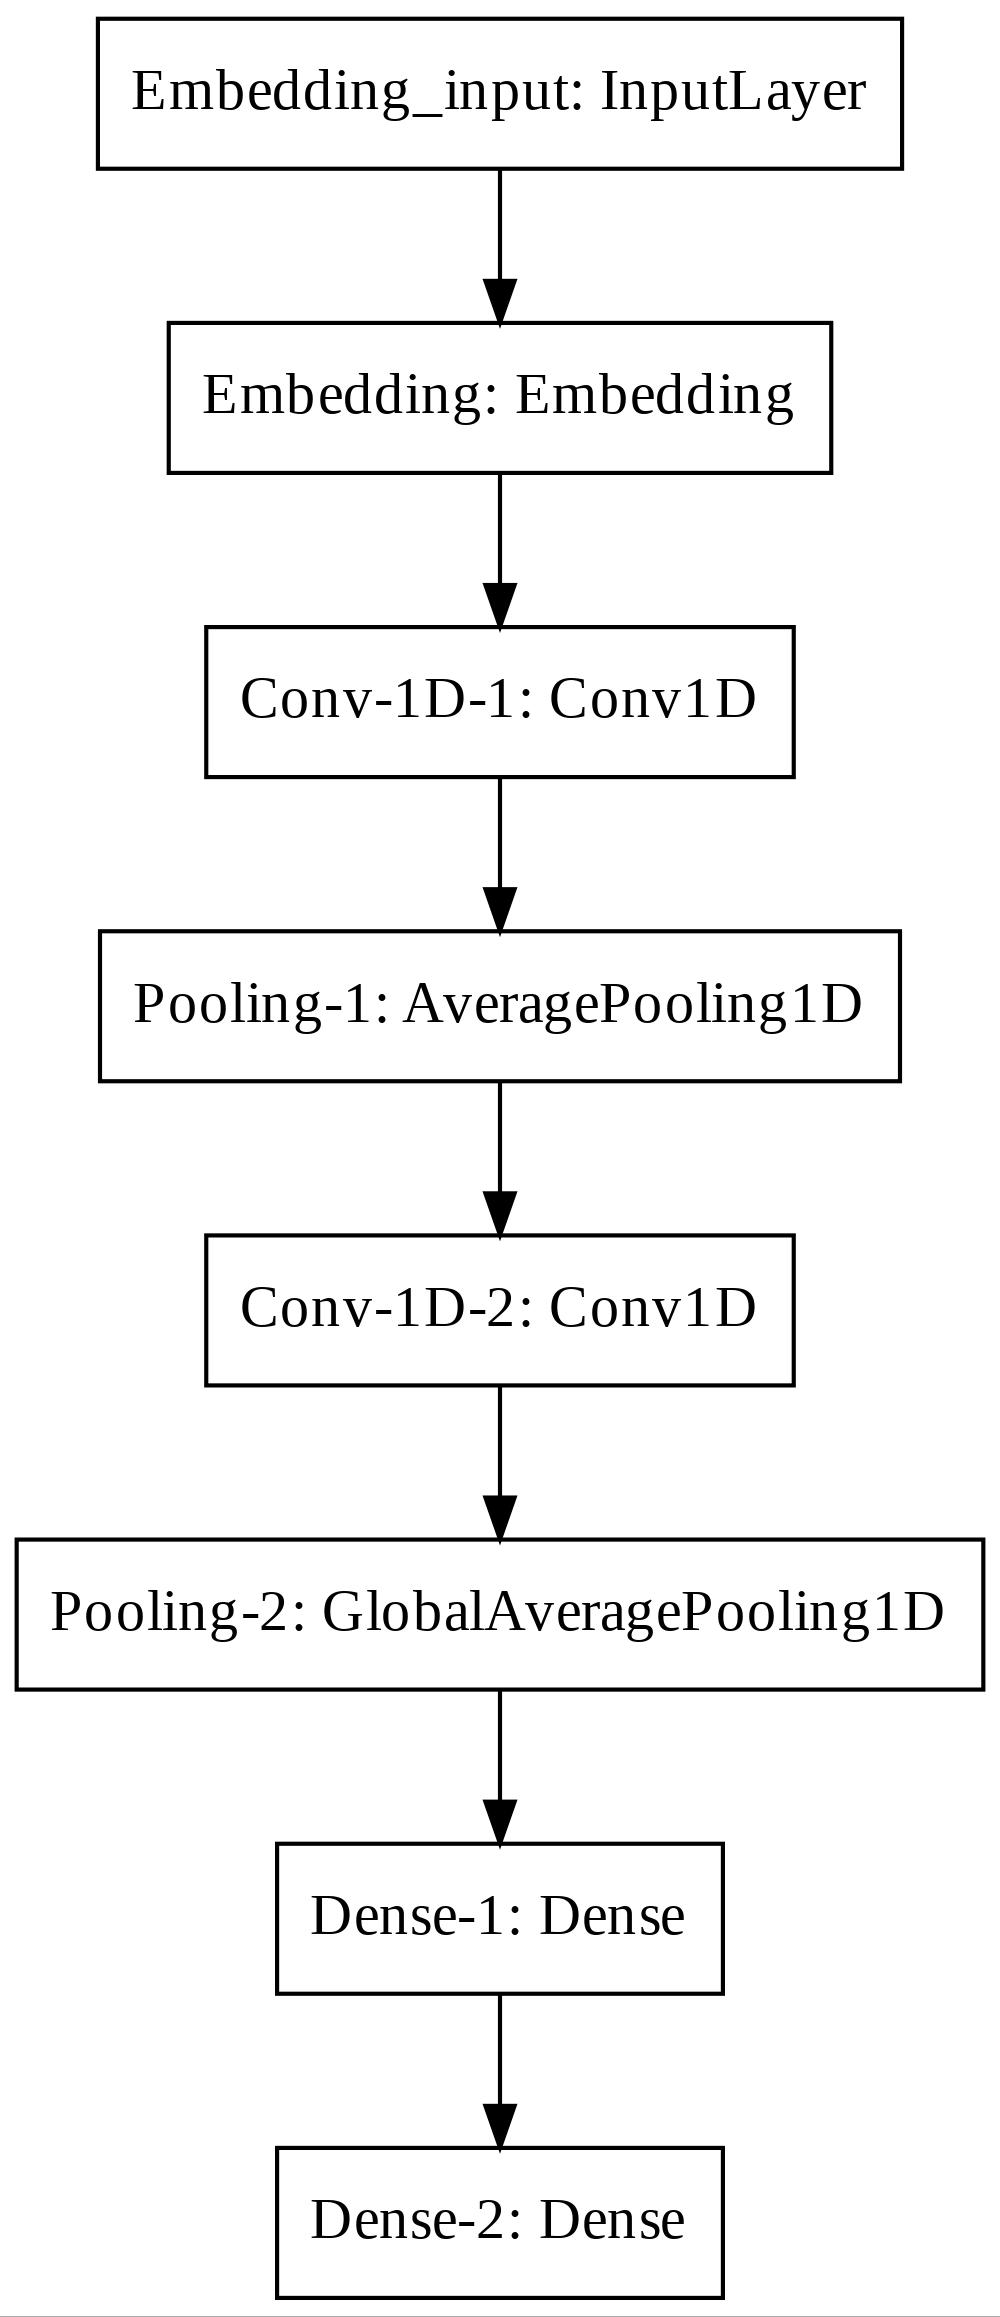

In [0]:
# flow charts of models
from tensorflow.keras.utils import plot_model
plot_model(model1, to_file='/content/drive/My Drive/model1.jpg', dpi=300)
plot_model(model2, to_file='/content/drive/My Drive/model2.jpg',dpi=300)
plot_model(model3, to_file='/content/drive/My Drive/model3.jpg', dpi=300)

In [0]:
#print results of latest epoch

print('model1 validation accuracy = ', history1.history['val_accuracy'][-1])
print('model2 validation accuracy = ', history2.history['val_accuracy'][-1])
print('model3 validation accuracy = ', history3.history['val_accuracy'][-1])




model1 validation accuracy =  0.6644264459609985
model2 validation accuracy =  0.9493927359580994
model3 validation accuracy =  0.9635627269744873


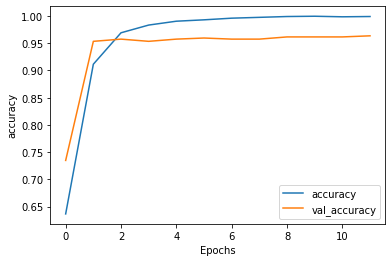

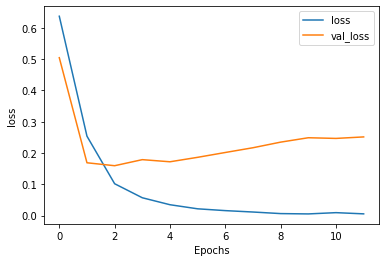

In [0]:
# print results of a model
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history3, 'accuracy')
plot_graphs(history3, 'loss')

In [0]:
# creat 3d scatterplot
import plotly.express as px
#reshape results
#dff = Results_Total

dff1 = Results_Total[{'Training_size', 'Prevalence', 'Model_Dense_Acc'}]
Dense = ['Dense']*len(Results_Total)
dff1['Model'] = Dense
dff1.rename(columns={'Model_Dense_Acc':'Accuracy'}, inplace=True)

dff2 = Results_Total[{'Training_size', 'Prevalence', 'Model_LSTM_Acc'}]
LSTM = ['LSTM']*len(Results_Total)
dff2['Model'] = LSTM
dff2.rename(columns={'Model_LSTM_Acc':'Accuracy'}, inplace=True)

dff3 = Results_Total[{'Training_size', 'Prevalence', 'Model_CNN_Acc'}]
CNN = ['CNN']*len(Results_Total)
dff3['Model'] = CNN
dff3.rename(columns={'Model_CNN_Acc':'Accuracy'}, inplace=True)


dfff = dff1
dfff = dfff.append(dff2)
dfff = dfff.append(dff3)
#print(dfff)
fig = px.scatter_3d(dfff, x='Prevalence', y='Training_size', z='Accuracy',
              color='Model')
fig.show()

# 2d scatterplot

fig2d1 = px.scatter(dfff, x="Training_size", y="Accuracy", color="Model" ,
                 size='Prevalence' )  #, hover_data=['  '])
fig2d1.show()

fig2d2 = px.scatter(dfff, x='Prevalence', y='Accuracy', color='Model' ,
                 size='Training_size' )  #, hover_data=['  '])
fig2d2.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [0]:
import plotly.express as px
df = px.data.iris()
fig = px.scatter_3d(df, x='sepal_length', y='sepal_width', z='petal_width',
              color='species')
fig.show()

In [0]:
model1.save("test_stepsize100.h5")

Klad

In [0]:
#AO additional metrics
#from sklearn.metrics import precision_recall_fscore_support


In [0]:
#gekopieerd:
#from transformers import BertTokenizer, BertModel

#tokenizer = BertTokenizer.from_pretrained("bert-base-dutch-cased")
#model = BertModel.from_pretrained("bert-base-dutch-cased")

#?????
